# Data explore Notebook
This notebook contains data processing and visualization. The input data is a JourneyToZero Kaggle competition.

https://www.kaggle.com/competitions/predict-electricity-consumption

In [38]:
import numpy as nb
import pandas as pd
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import holidays
%matplotlib inline


### Importing data from kaggle and external sources

In [2]:
from google.colab import files
files.upload() # Give kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tiitvaino","key":"ced67cd36a3bf255ff49cebde94923fe"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

unzip:  cannot find or open predict-electricity-consumption.zip, predict-electricity-consumption.zip.zip or predict-electricity-consumption.zip.ZIP.


In [11]:
!kaggle competitions download -c predict-electricity-consumption

  0% 0.00/174k [00:00<?, ?B/s]
100% 174k/174k [00:00<00:00, 62.7MB/s]


In [12]:
!unzip predict-electricity-consumption.zip

Archive:  predict-electricity-consumption.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Preprocessing

In [13]:
def extract_time(dataset):
    #https://www.pluralsight.com/guides/machine-learning-for-time-series-data-in-python
    dataset.loc[:,'time'] = pd.to_datetime(dataset.loc[:,'time'], format="%Y-%m-%d %H:%M:%S", utc=True)
    dataset['date'] = dataset['time'].dt.date
    dataset['hour'] = dataset['time'].dt.hour

    dataset['year'] = pd.DatetimeIndex(dataset['date']).year
    dataset['month'] = pd.DatetimeIndex(dataset['date']).month
    dataset['day'] = pd.DatetimeIndex(dataset['date']).day
    #dataset['dayofyear'] = pd.DatetimeIndex(dataset['date']).dayofyear
    #dataset['weekofyear'] = pd.DatetimeIndex(dataset['date']).weekofyear
    dataset['weekday'] = pd.DatetimeIndex(dataset['date']).weekday
    dataset['week_hour'] = (dataset.weekday-1) * dataset.hour
    dataset['quarter'] = pd.DatetimeIndex(dataset['date']).quarter
    dataset['is_month_start'] = pd.DatetimeIndex(dataset['date']).is_month_start
    dataset['is_month_end'] = pd.DatetimeIndex(dataset['date']).is_month_end

In [14]:
def add_interest_rate(dataset):
    ir_2021 = [0.2,0.6,1.1,1.9,3.6,3.8,5,5,6.6,7,8.8,12.2]
    ir_2022 = [11.3,12.0,15.2,18.8,20.0,21.9,22.8,24.8,23.7,22.5,None,None]
    inflation_rate = {2021:ir_2021, 2022:ir_2022}
    dataset['inflation'] = dataset.apply(lambda row: inflation_rate[row['year']][row['month']-1], axis=1)
    dataset['inflation'] = dataset['inflation'].astype(float)
    return dataset

In [15]:
def extract_holidays(dataset):
    ee_holidays = holidays.Estonia()
    dataset['holiday'] = dataset['date'].apply(lambda datex: 1 if datex in ee_holidays else 0)
    dataset['holiday'] = dataset['holiday'].astype(bool)

In [40]:
def extract_features(dataset):
    extract_time(dataset)
    add_interest_rate(dataset)
    extract_holidays(dataset)

In [17]:
def read_dataset(file_name) -> pd.DataFrame:
    return pd.read_csv(file_name)

In [18]:
train_df = read_dataset('train.csv')
test_df = read_dataset('test.csv')

# Look into raw data

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8592 entries, 0 to 8591
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8592 non-null   object 
 1   temp         8592 non-null   float64
 2   dwpt         8592 non-null   float64
 3   rhum         8592 non-null   float64
 4   prcp         2159 non-null   float64
 5   snow         119 non-null    float64
 6   wdir         8592 non-null   float64
 7   wspd         8592 non-null   float64
 8   wpgt         8592 non-null   float64
 9   pres         8592 non-null   float64
 10  coco         8396 non-null   float64
 11  el_price     8592 non-null   float64
 12  consumption  8590 non-null   float64
dtypes: float64(12), object(1)
memory usage: 872.8+ KB


## Lets plot them

In [30]:
train_df.columns

Index(['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'coco', 'el_price', 'consumption'],
      dtype='object')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


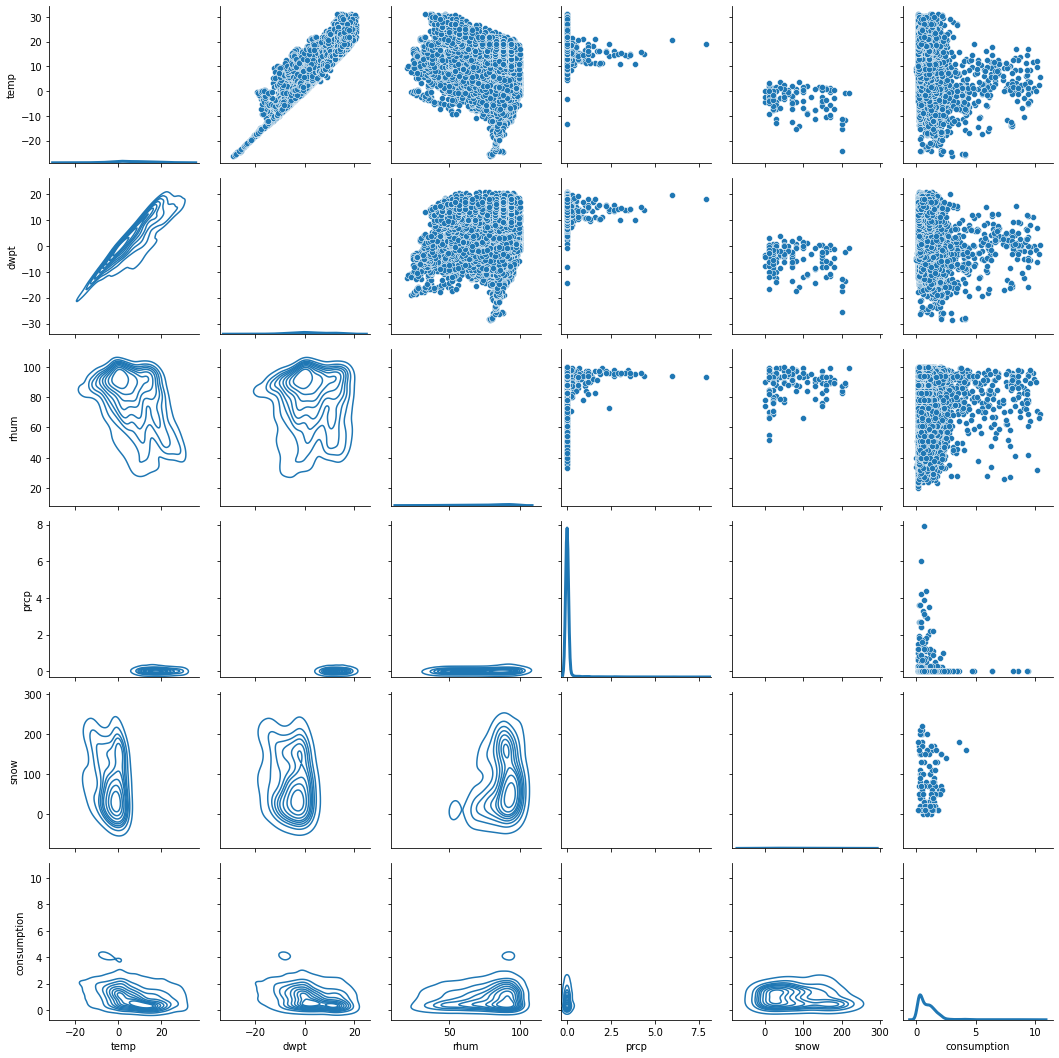

In [34]:
g = sns.PairGrid(train_df[['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'consumption']])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

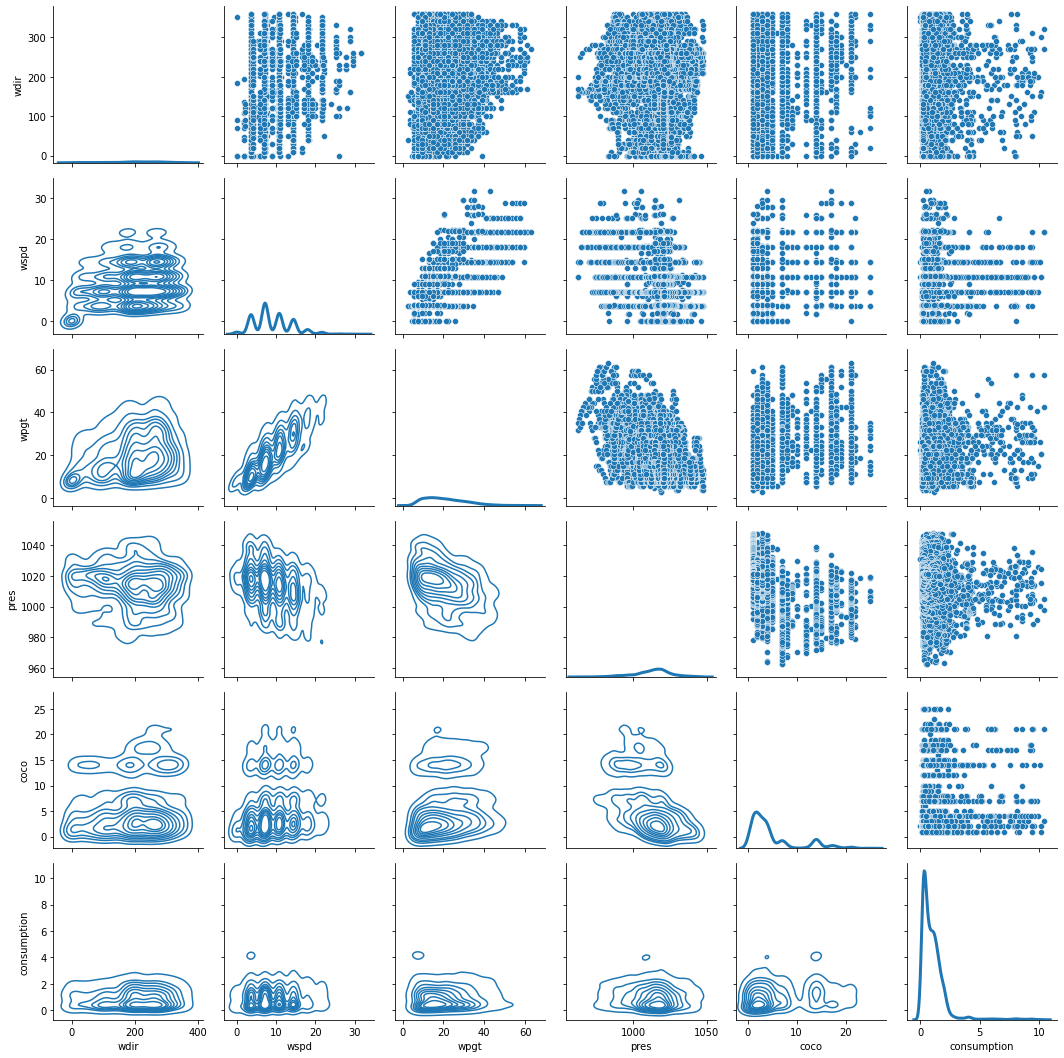

In [75]:
g = sns.PairGrid(train_df[[ 'wdir', 'wspd', 'wpgt', 'pres', 'coco','consumption']])
#g.map(sns.scatterplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

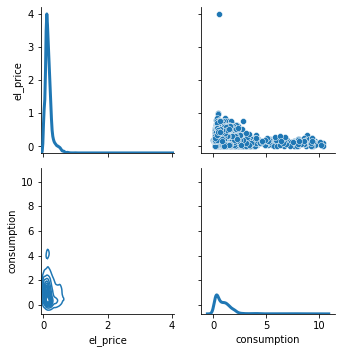

In [35]:
g = sns.PairGrid(train_df[['time', 'el_price', 'consumption']])
#g.map(sns.scatterplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

# Look into processed data

In [41]:
extract_features(train_df)
extract_features(test_df)

In [76]:
train_df.columns

Index(['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'coco', 'el_price', 'consumption', 'date', 'hour', 'year',
       'month', 'day', 'weekday', 'week_hour', 'quarter', 'is_month_start',
       'is_month_end', 'inflation', 'holiday'],
      dtype='object')

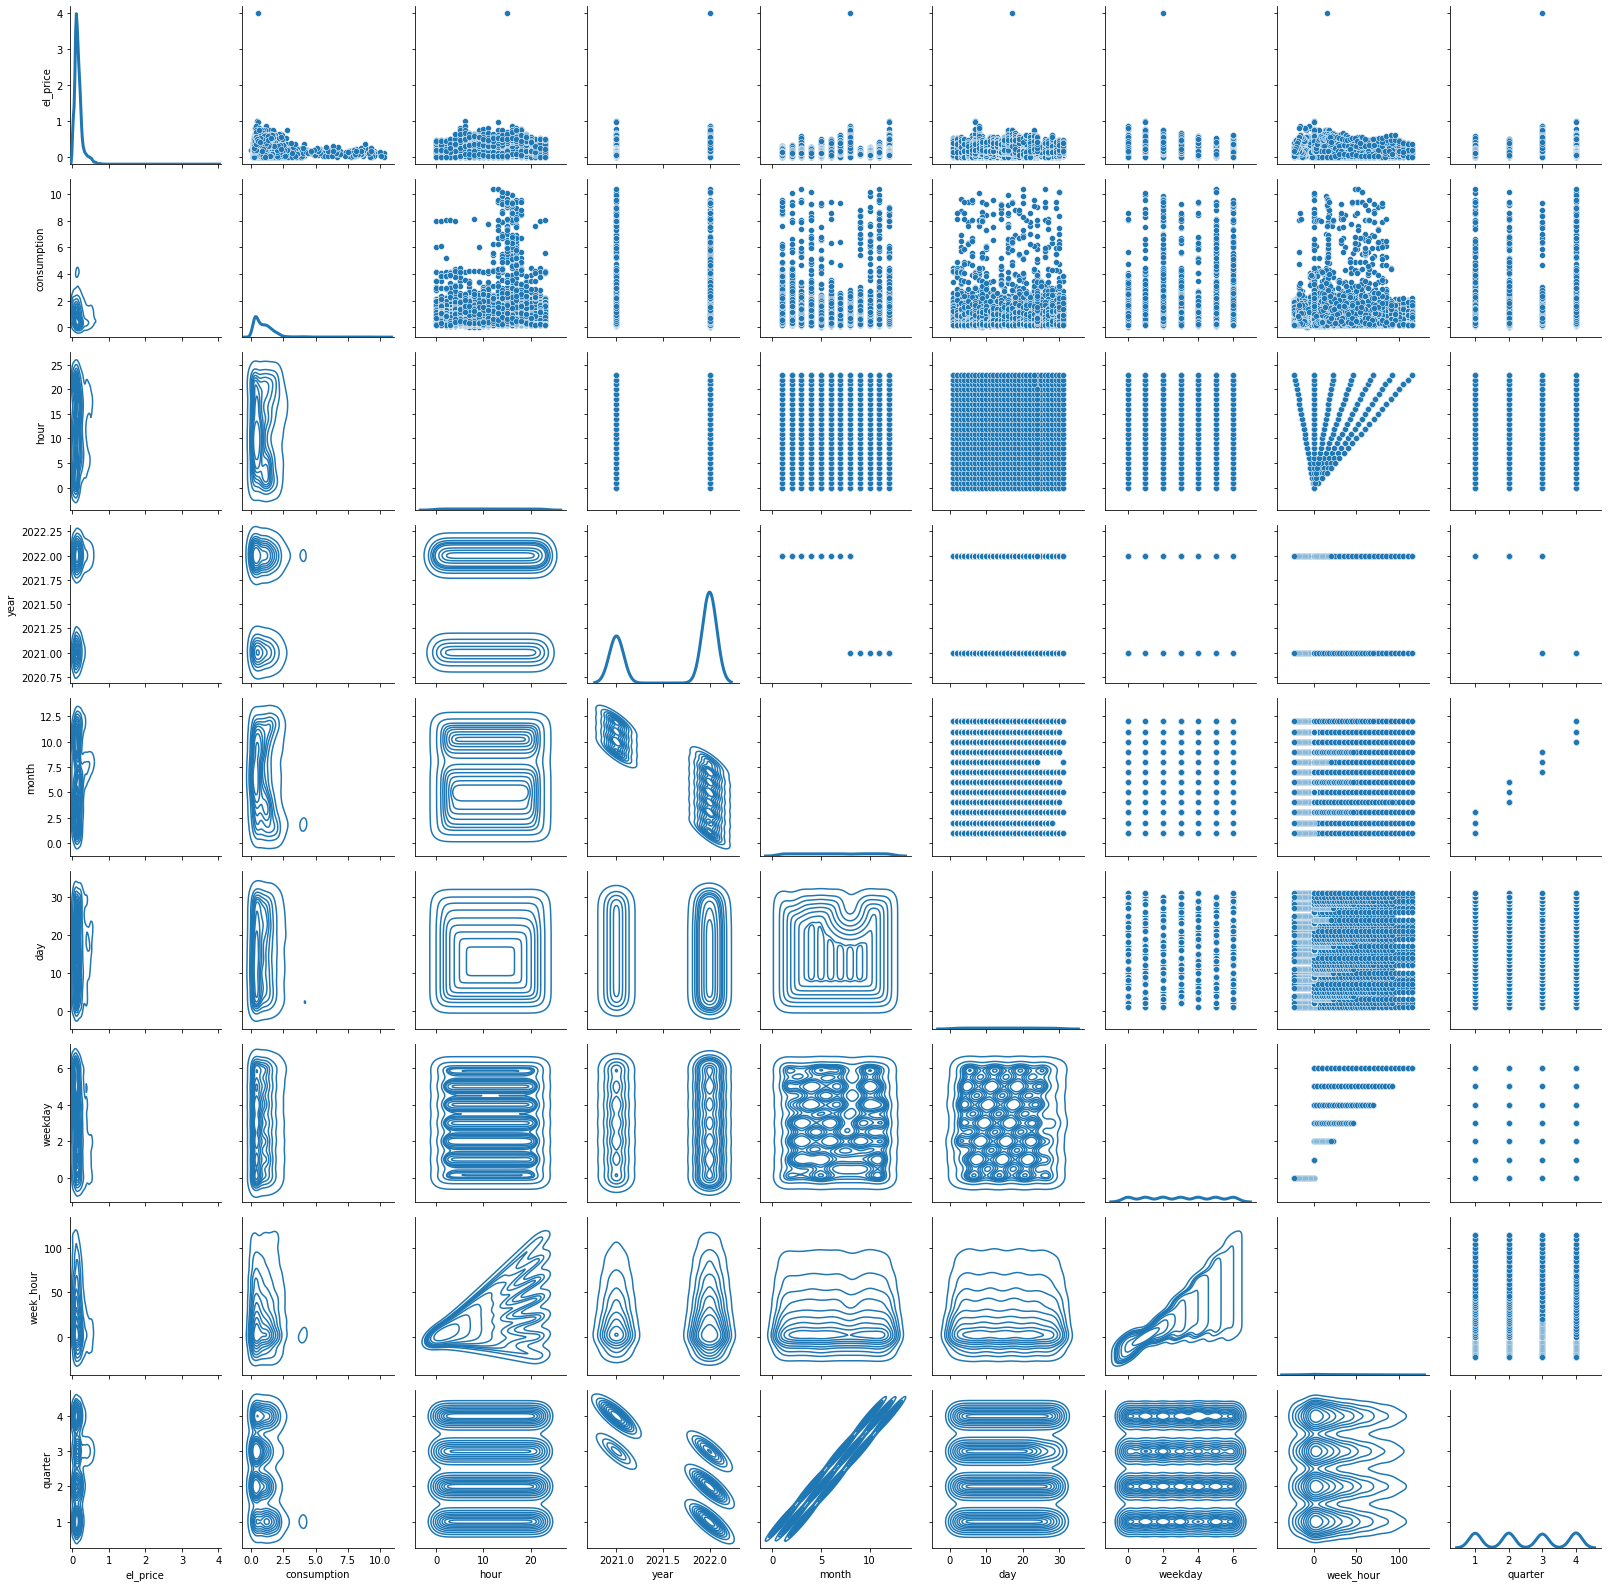

In [81]:
g = sns.PairGrid(train_df[['el_price', 'consumption','hour', 'year', 'month', 'day', 'weekday', 'week_hour', 'quarter']])
#g.map(sns.scatterplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

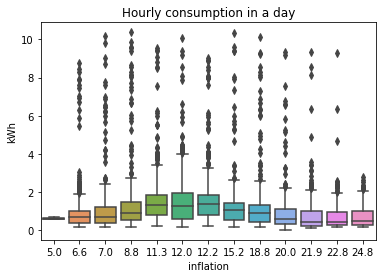

In [80]:
# https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
sns.boxplot(data=train_df, x='inflation', y='consumption')
plt.ylabel('kWh')
plt.title('Hourly consumption in a day')
plt.show()

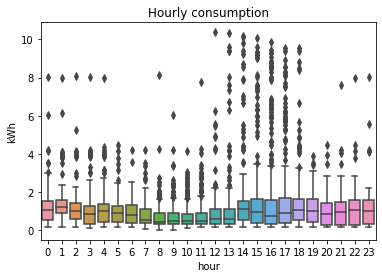

In [59]:
# https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
sns.boxplot(data=train_df, x='hour', y='consumption')
plt.ylabel('kWh')
plt.title('Hourly consumption in a day')
plt.show()

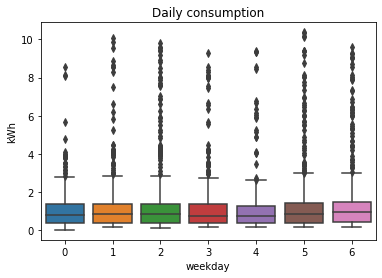

In [60]:
sns.boxplot(data=train_df, x='weekday', y='consumption')
plt.ylabel('kWh')
plt.title('Daily consumption in a week')
plt.show()

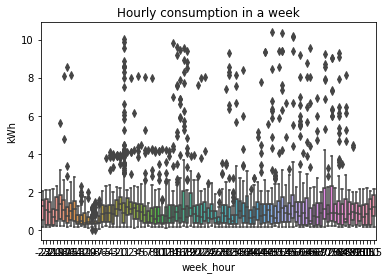

In [63]:
sns.boxplot(data=train_df, x='week_hour', y='consumption')
plt.ylabel('kWh')
plt.title('Hourly consumption in a week')
plt.show()

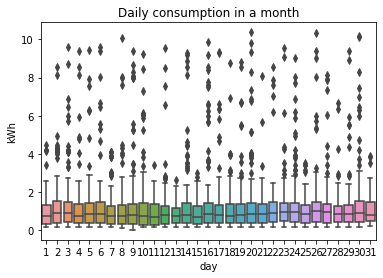

In [61]:
sns.boxplot(data=train_df, x='day', y='consumption')
plt.ylabel('kWh')
plt.title('Daily consumption in a month')
plt.show()

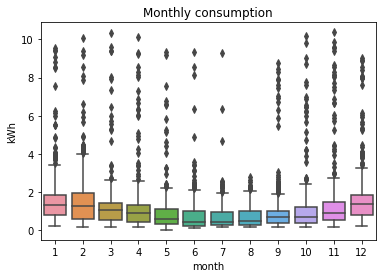

In [58]:
sns.boxplot(data=train_df, x='month', y='consumption')
plt.ylabel('kWh')
plt.title('Monthly consumption in a year')
plt.show()

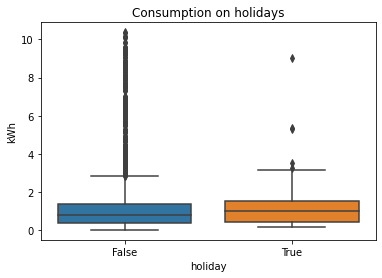

In [66]:
sns.boxplot(data=train_df, x='holiday', y='consumption')
plt.ylabel('kWh')
plt.title('Consumption on holidays')
plt.show()

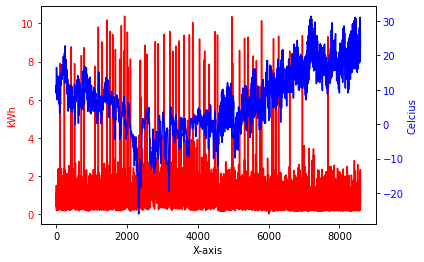

In [74]:
# https://pythonguides.com/matplotlib-two-y-axes/
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('X-axis') 
ax1.set_ylabel('kWh', color = 'red') 
ax1.plot(train_df.index, train_df.consumption, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Celcius', color = 'blue') 
ax2.plot(train_df.index,  train_df.temp, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 

# Display

plt.show()

In [64]:
train_df.columns

Index(['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'coco', 'el_price', 'consumption', 'date', 'hour', 'year',
       'month', 'day', 'weekday', 'week_hour', 'quarter', 'is_month_start',
       'is_month_end', 'inflation', 'holiday'],
      dtype='object')